In [2]:
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.common import Loc
from dotenv import load_dotenv
import boto3
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import TrainingLogsViewer
import matplotlib.pyplot as plt

project_name = 'antecedents_project'
dataset_name = 'antecedents_simple_dataset'
bucket = 'antecedents-simple'
load_dotenv(Loc.root_path / 'environment.env')

def _load_metrics_df(rs):
    df = pd.DataFrame(FileIO.read_pickle(
        rs.get_path('output/history.pkl')))
    rdf = df.drop('timestamp', axis=1).unstack().to_frame().reset_index()
    rdf.columns = ['metric', 'ordinal', 'value']
    if 'timestamp' in df.columns:
        rdf = rdf.merge(pd.to_datetime(
            df.timestamp), left_on='ordinal', right_index=True).reset_index(drop=True)
    return rdf

Первый запуск.
Загрузка бандла:

In [11]:
#S3YandexHandler.create_bucket(bucket)

In [29]:
bundle_folder = Loc.bundles_path/'antcd/simple/last'
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'

In [13]:
#S3YandexHandler.upload_folder(bucket, s3path, bundle_folder)

In [3]:
from tg.grammar_ru.common import DataBundle
db = DataBundle.load(bundle_folder)
db

{'index': {'shape': (101065, 8), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (570787, 16), 'index_name': 'word_id'}, 'slovnet': {'shape': (570787, 17), 'index_name': 'word_id'}, 'src': {'shape': (570787, 14), 'index_name': None}}

In [5]:
s3_path = r'datasphere/antecedents_project'

kwargs = S3YandexHandler._get_access_keys()
s3_resource = boto3.resource('s3', **kwargs)
bucket_obj = s3_resource.Bucket(bucket)

keys = [z.key for z in bucket_obj.objects.filter(Prefix=s3_path)]
for key in keys:
    print(key)

datasphere/antecedents_project/datasets/antecedents_simple_dataset/add_info.pkl
datasphere/antecedents_project/datasets/antecedents_simple_dataset/index.parquet
datasphere/antecedents_project/datasets/antecedents_simple_dataset/pymorphy.parquet
datasphere/antecedents_project/datasets/antecedents_simple_dataset/slovnet.parquet
datasphere/antecedents_project/datasets/antecedents_simple_dataset/src.parquet
datasphere/antecedents_project/exceptions/antc_task 07:44:15.020543.txt
datasphere/antecedents_project/exceptions/antc_task 09:13:38.508279.txt
datasphere/antecedents_project/exceptions/antc_task 12:48:42.138251.txt
datasphere/antecedents_project/exceptions/antc_task 13:19:53.252689.txt
datasphere/antecedents_project/job_info/job_antecedents_project_07:44:15.020470.txt
datasphere/antecedents_project/job_info/job_antecedents_project_09:13:38.508218.txt
datasphere/antecedents_project/job_info/job_antecedents_project_12:48:42.138251.txt
datasphere/antecedents_project/job_info/job_anteceden

Первый результат на 50 эпох:

In [31]:
from pathlib import Path
from yo_fluq_ds import *
import subprocess
from tg.common.delivery.training.architecture import ResultPickleReader

task_id = 'antc_task 05:50:39.308735'
rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\output-unzipped'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = task_id

In [36]:
metrics.head(8)

,metric,ordinal,value,timestamp,job_id
0,roc_auc_score_test,0,0.501481,2022-12-15 05:52:44.735476,antc_task 05:50:39.308735
1,roc_auc_score_display,0,0.503828,2022-12-15 05:52:44.735476,antc_task 05:50:39.308735
2,loss,0,0.127502,2022-12-15 05:52:44.735476,antc_task 05:50:39.308735
3,iteration,0,0.000000,2022-12-15 05:52:44.735476,antc_task 05:50:39.308735
4,roc_auc_score_test,1,0.516618,2022-12-15 05:54:45.970556,antc_task 05:50:39.308735
5,roc_auc_score_display,1,0.518373,2022-12-15 05:54:45.970556,antc_task 05:50:39.308735
6,loss,1,0.126335,2022-12-15 05:54:45.970556,antc_task 05:50:39.308735
7,iteration,1,1.000000,2022-12-15 05:54:45.970556,antc_task 05:50:39.308735


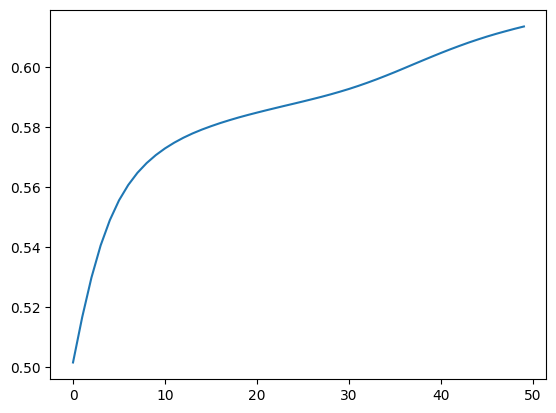

In [37]:
import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'))

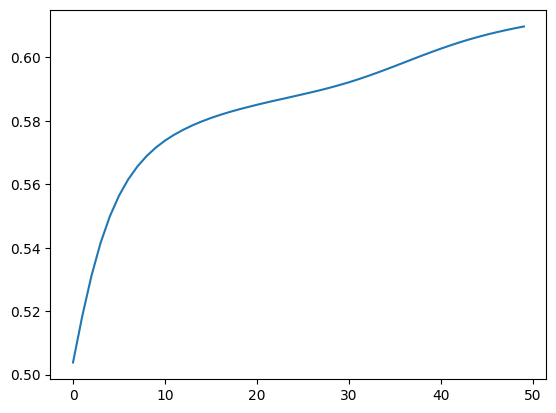

In [38]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'))

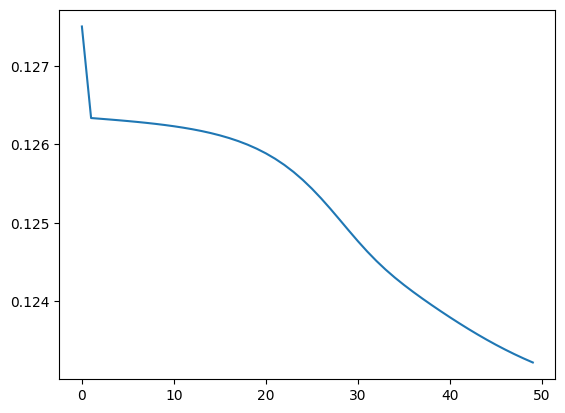

In [39]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

Исправление разбиения бандла (строки, относящиеся к одному местоимению, вместе попадают в `test`, `train` или `display`):

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def train_display_test_split(df, group_column, test_size=0.3, display_size=0.3):
    classes, group_indices = np.unique(df[group_column], return_inverse=True)
    train_group, test_group = train_test_split(
        classes,
        test_size=test_size)
    train_group, display_group = train_test_split(
        train_group,
        test_size=display_size/(1-test_size))
    split = np.where(
        df[group_column].isin(test_group),
        'test',
        np.where(df[group_column].isin(display_group),
                 'display',
                 'train'))
    return pd.Series(split, index = df.index)

db['index']['split'] = train_display_test_split(db['index'], 'pronoun_word_id')
db.index

,pronoun_word_id,pronoun_sentence_id,candidate_word_id,candidate_sentence_id,candidate_distance,label,word_distance,split
sample_id,,,,,,,,
0,7,0,4,0,1,1,3,train
1,7,0,5,0,0,0,2,train
2,514887,514880,514884,514880,1,1,3,test
3,514887,514880,514885,514880,0,0,2,test
4,1903357,1903337,1903342,1903335,3,0,12,train
...,...,...,...,...,...,...,...,...
101060,22837552,22837430,22837513,22837429,4,0,33,test
101061,22837552,22837430,22837524,22837430,3,0,25,test
101062,22837552,22837430,22837537,22837430,2,0,14,test


In [15]:
bundle_folder = Loc.bundles_path/'antcd/simple/last'
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
#db.save(bundle_folder)
#S3YandexHandler.upload_folder(bucket, s3path, bundle_folder)

600 epochs, learning_rate=1

In [14]:
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader

rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\600'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = task_id

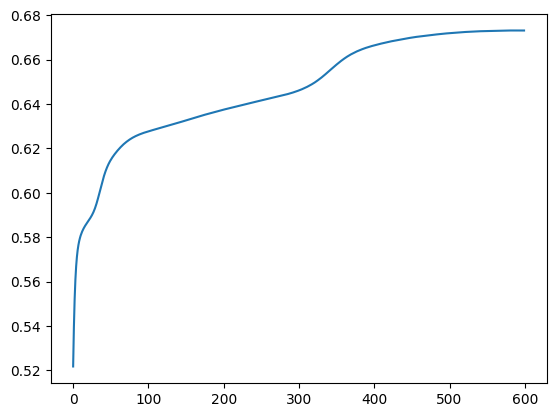

In [15]:
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import TrainingLogsViewer

import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'))

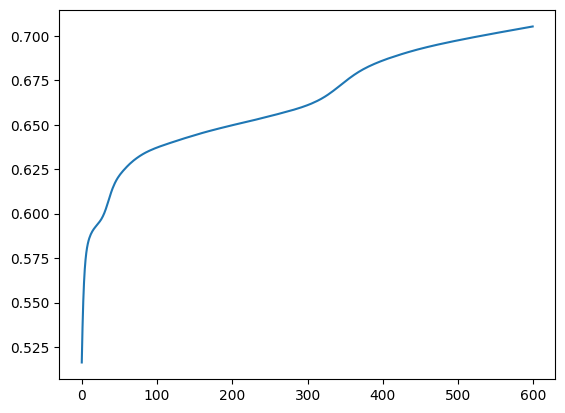

In [16]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'))

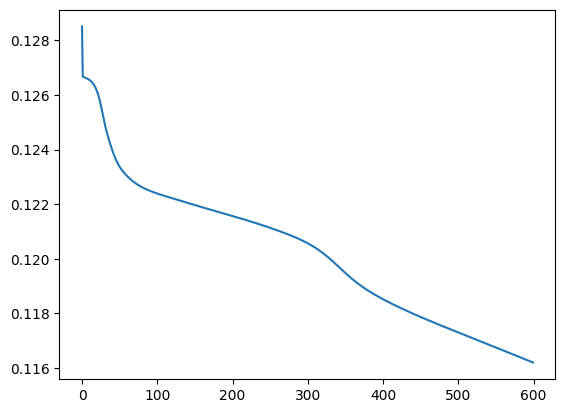

In [17]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

Adam optimizer:

In [23]:
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader

rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\adam'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 18:23:40.005562'

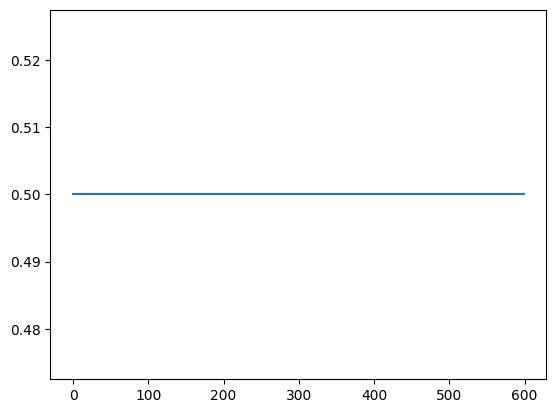

In [26]:
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import TrainingLogsViewer

import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')

Вот почему важно не забывать проверять новые параметры на игрушечных наборах данных.

Adam optimizer, training loss 0.01

In [4]:
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader

rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\adam001'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 16:53:10.808247'

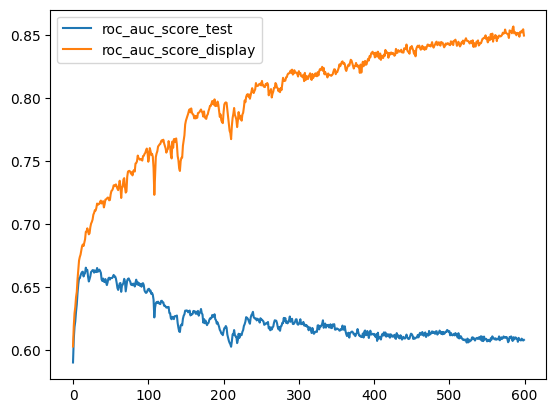

In [11]:
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import TrainingLogsViewer

import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

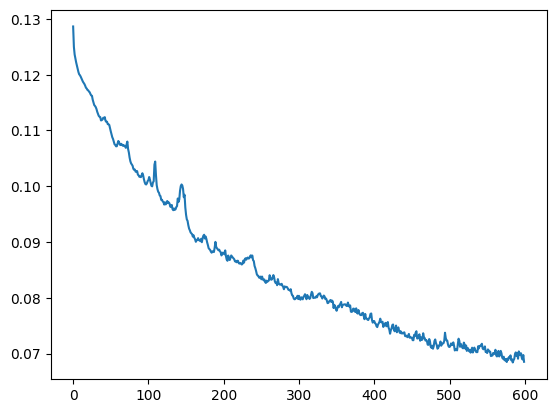

In [8]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

Замены Plain-сети

AttentionNetwork:

In [3]:
from pathlib import Path
from yo_fluq_ds import *
from tg.common.delivery.training.architecture import ResultPickleReader

rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\adam_attention'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 12:01:21.140130'

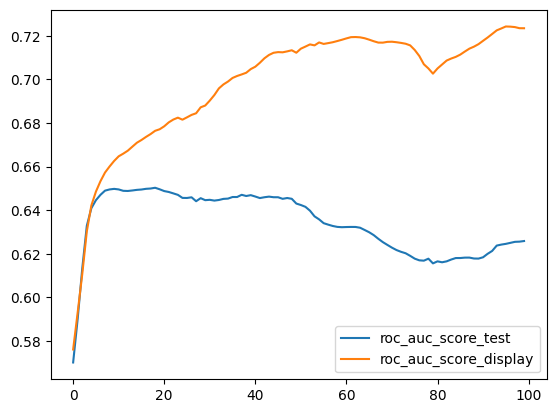

In [4]:
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import TrainingLogsViewer

import matplotlib.pyplot as plt
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

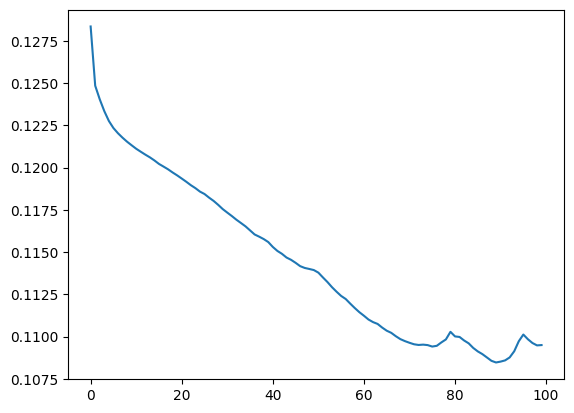

In [5]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

LSTMNetwork/LSTM_BicontextualFinalizer

In [7]:
rs = None
try:
    rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\adam_lstm_bfin'))
except:
    raise
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 15:54:19.829947'

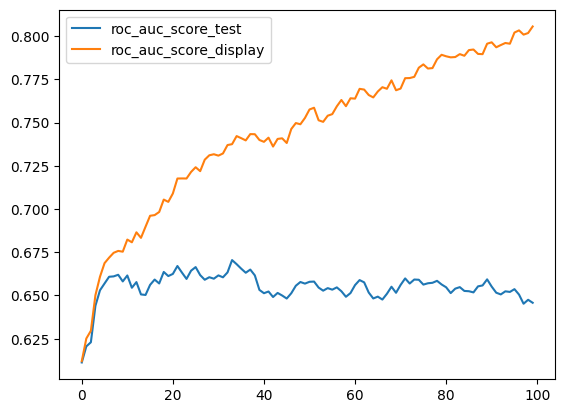

In [8]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

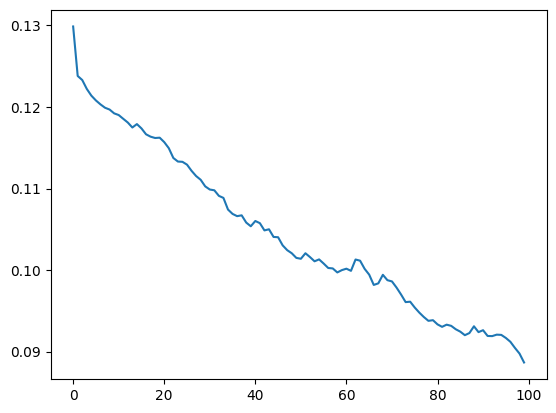

In [9]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

Dropout, attention

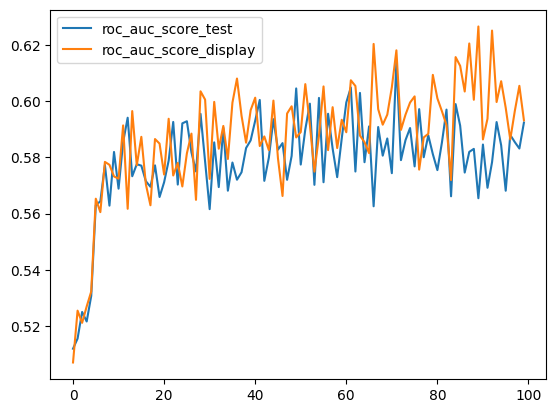

In [6]:
rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\att_dropout'))
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 15:10:33.544743'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

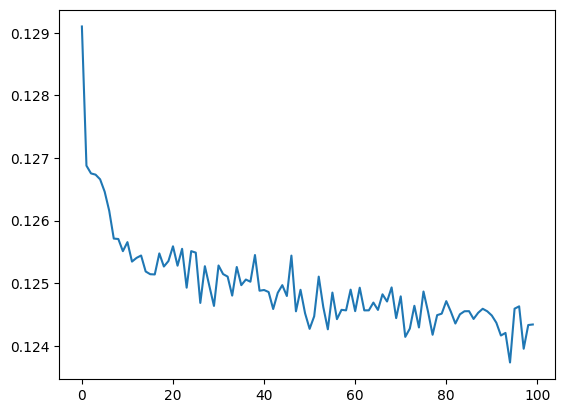

In [8]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

dropout, LSTM

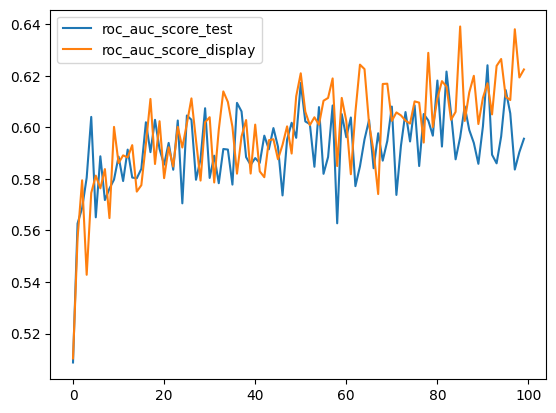

In [12]:
rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\lstm_dropout'))
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 17:56:13.315312'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

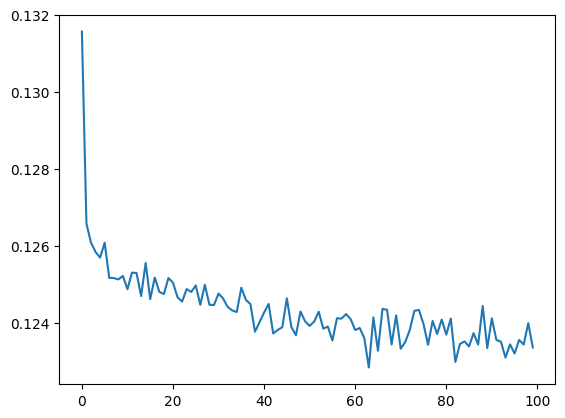

In [13]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'loss'))

Dropout, ReLU, Attention

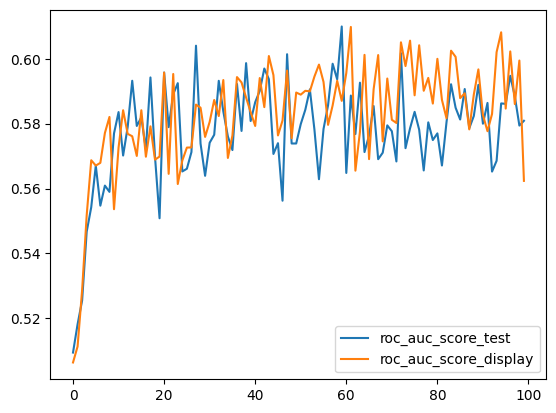

In [6]:
rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\attn_drop_relu'))
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 08:44:30.993556'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

Dropout, ReLU,LSTM

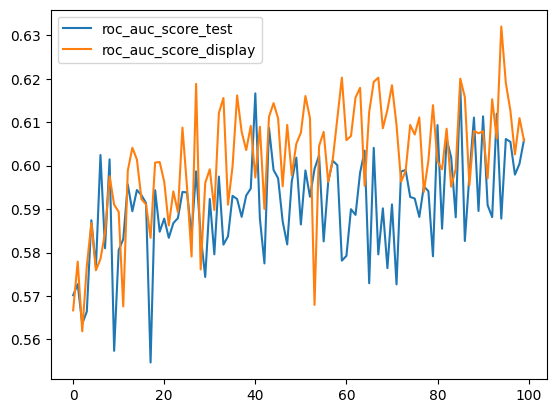

In [14]:
rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\lstm_relu_dropout'))
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 17:56:13.315312'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

Dropout 0.5, Attention

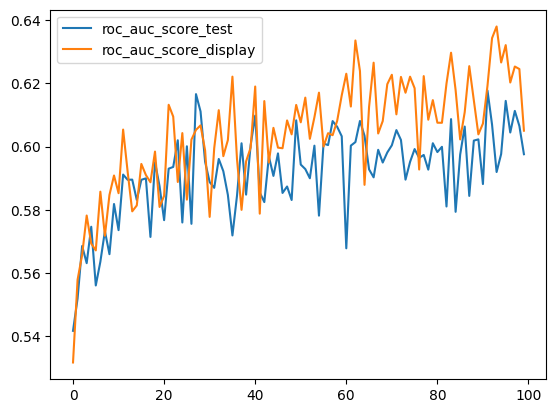

In [4]:
rs = ResultPickleReader(Path(r'c:\users\alexandra\desktop\05_dr_attn'))
metrics = _load_metrics_df(rs)
metrics['job_id'] = 'antc_task 08:45:58.413102'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

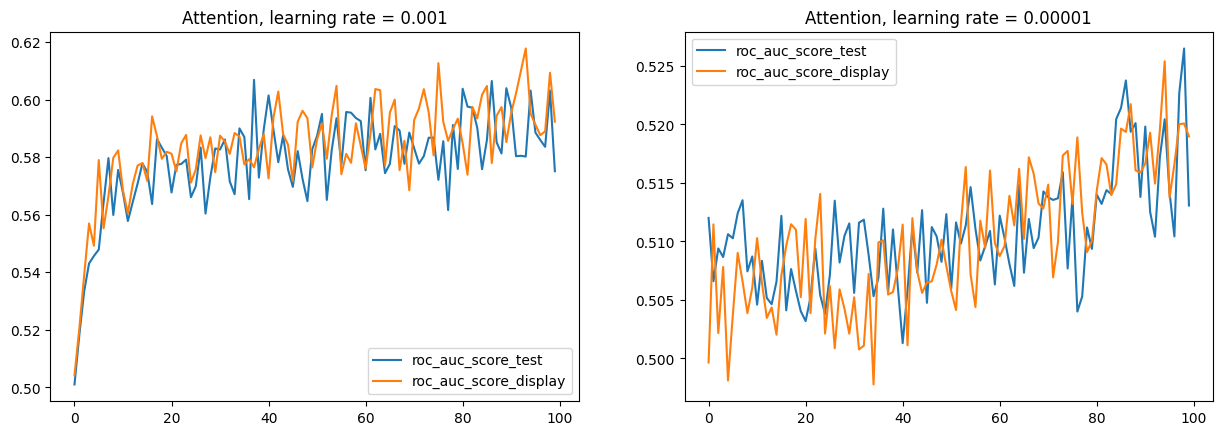

In [28]:
metrics1 = _load_metrics_df(ResultPickleReader(Path(r'c:\users\alexandra\desktop\0.001attn')))
metrics1['job_id'] = 'antc_task 13:43:20.471613'
metrics2 = _load_metrics_df(ResultPickleReader(Path(r'c:\users\alexandra\desktop\0.00001attn')))
metrics2['job_id'] = 'antc_task 13:46:32.028242'
def fill(subplot, title, metrics):
    subplot.set_title(title)
    subplot.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
    subplot.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
    subplot.legend()
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fill(axs[0], 'Attention, learning rate = 0.001', metrics1)
fill(axs[1], 'Attention, learning rate = 0.00001', metrics2)

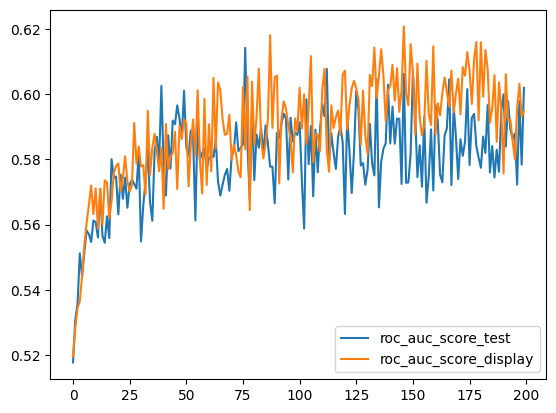

In [5]:
metrics = _load_metrics_df(ResultPickleReader(Path(r'c:\users\alexandra\desktop\6context')))
metrics['job_id'] = 'antc_task 19:20:35.977834'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

In [8]:
from tg.grammar_ru.ml.features import SyntaxStatsFeaturizer, SyntaxTreeFeaturizer

tree_f = SyntaxTreeFeaturizer()
tree_f.featurize(db)
stats_f = SyntaxStatsFeaturizer()
stats_f.featurize(db)

In [18]:
bundle_folder = Loc.bundles_path/'antcd/simple/fts'
#db.save(bundle_folder)
s3path = f'datasphere/{project_name}/datasets/more_features_simple_dataset'
#S3YandexHandler.upload_folder(bucket, s3path, bundle_folder)

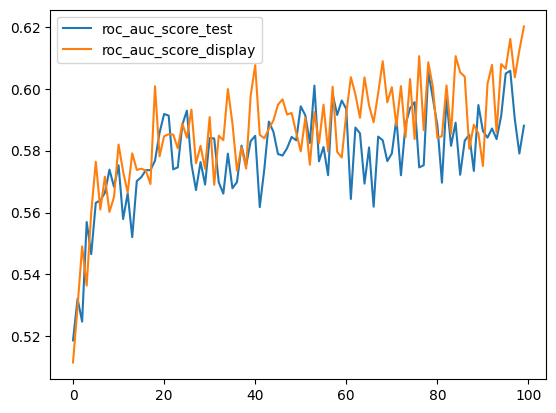

In [4]:
metrics = _load_metrics_df(ResultPickleReader(Path(r'c:\users\alexandra\desktop\features3')))
metrics['job_id'] = 'antc_task 07:42:39.155785'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()

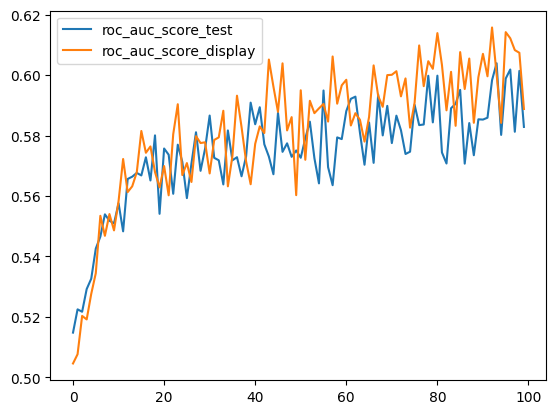

In [6]:
metrics = _load_metrics_df(ResultPickleReader(Path(r'c:\users\alexandra\desktop\features6')))
metrics['job_id'] = 'antc_task 07:43:43.408189'
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_test'), label='roc_auc_score_test')
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'roc_auc_score_display'), label='roc_auc_score_display')
plt.legend()